# Federated Learning with LLaVA-NeXT-Video (Jupyter Notebook)
**Goal**: Fine-tune a violence detection model across decentralized clients without sharing raw video data.

## Key Features:
- Uses **QLoRA** (4-bit quantization) for efficient federated training.
- **Flower** framework for federated averaging.
- Simulates 4 clients + 1 server in one notebook.

In [1]:
# !pip install kagglehub

# !pip install opencv-python-headless
# !pip install decord
# !pip install flwr
# !pip install peft
# !pip install transformers
# !pip install torchvision
# !pip install datasets
# !pip install av

# !pip install -q sentencepiece accelerate bitsandbytes

# !pip install codecarbon
# !pip install scikit-learn
# !pip install seaborn

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
  Using cached decord-0.6.0-py3-none-manylinux2010_x86_64.whl.metadata (422 bytes)
Using cached decord-0.6.0-py3-none-manylinux2010_x86_64.whl (13.6 MB)
  Using cached flwr-1.18.0-py3-none-any.whl.metadata (15 kB)
  Using cached grpcio-1.71.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached iterators-0.0.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached pathspec-0.12.1-py3-none-any.whl.metadata (21 kB)
  Using cached protobuf-4.25.7-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached pycryptodome-3.22.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 

In [3]:
import torch
import os
import json
import cv2
import av

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

from codecarbon import EmissionsTracker

import kagglehub
from pathlib import Path
from random import sample

from datasets import Dataset

from decord import VideoReader, cpu
from dataclasses import dataclass
from transformers import (
    AutoProcessor,
    LlavaNextVideoForConditionalGeneration,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

import flwr as fl
from flwr.server import ServerConfig, start_server
from flwr.server.strategy import FedAvg
import threading

import logging

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
logging.getLogger("codecarbon").setLevel(logging.WARNING)

In [5]:
# Download dataset
path = kagglehub.dataset_download("yash07yadav/project-data")
print(f"Dataset downloaded to: {path}")

# Define paths
base_path = Path(path) / "Complete Dataset" / "train"
fight_dir = base_path / "Fight"
non_fight_dir = base_path / "NonFight"

# Verify download
print(f"\nFound {len(list(fight_dir.glob('*')))} fight videos")
print(f"Found {len(list(non_fight_dir.glob('*')))} non-fight videos")

Dataset downloaded to: /home/jovyan/.cache/kagglehub/datasets/yash07yadav/project-data/versions/1

Found 1000 fight videos
Found 1000 non-fight videos


In [6]:
def create_client_files(client_count=4, samples_per_client=100):
    # Get all video paths
    fight_videos = [str(f) for f in fight_dir.glob('*')]
    nonfight_videos = [str(f) for f in non_fight_dir.glob('*')]

    # Create balanced datasets for clients
    for client_id in range(client_count):
        client_data = {
            "videos": (
                [{"path": p, "label": 1} for p in sample(fight_videos, samples_per_client//2)] +
                [{"path": p, "label": 0} for p in sample(nonfight_videos, samples_per_client//2)]
            )
        }

        with open(f'client{client_id}_data.json', 'w') as f:
            json.dump(client_data, f)

    print(f"Created {client_count} client files with {samples_per_client} samples each")

# create_client_files()

In [7]:
@dataclass
class Config:
    MODEL_ID = "llava-hf/LLaVa-NeXT-Video-7b-hf"
    NUM_FRAMES = 24
    BATCH_SIZE = 1
    USE_QLORA = True
    LORA_RANK = 16
    SERVER_ADDRESS = "127.0.0.1:8080"
    GRADIENT_ACCUMULATION_STEPS = 4 

    BATCH_SIZE = 2
    GRAD_ACCUM_STEPS = 4
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    MAX_STEPS = 100
    LOGGING_STEPS = 50
    SAVE_STEPS = 200

config = Config()

In [8]:
# Optimized Federated Client for LLaVA Video Processing
class LlavaClient(fl.client.NumPyClient):
    def __init__(self, dataset_path, client_id):
        """Initialize client with memory-efficient video processing"""
        # Clear GPU cache before initialization
        torch.cuda.empty_cache()

        self.client_id = client_id

        # Ensure the output directory exists
        os.makedirs(f"emissions/client_{client_id}", exist_ok=True)

        # Initialize trackers
        self.emissions_tracker = EmissionsTracker(
            project_name=f"LLaVa_Load_Model_Client_{client_id}",
            measure_power_secs=1,
            output_dir=f"emissions/client_{client_id}",
            save_to_file=True,
            log_level="warning"
        )
        
        # Load and validate dataset
        with open(dataset_path) as f:
            data = json.load(f)
            self.dataset = data
            print(f"Loaded {len(self.dataset)} samples from {dataset_path}")

        # Initialize model and track emissions
        self.emissions_tracker.start()
        self.model, self.processor = get_model_and_processor()

        self.result = self.prediction()
        self.emissions_tracker.stop()
        
        self.evaluation(self.result)

        print(f"Client ready on device {next(self.model.parameters()).device}")
        

    def text_output(self, video_path):
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "video", "path": video_path},
                    {"type": "text", "text": "Analyze the video. Is this a fight scene? Answer with only yes or no"},
                    ],
            },
        ]
        
        inputs = self.processor.apply_chat_template(
            conversation,
            num_frames=24,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(self.model.device, torch.float16)
        
        out = self.model.generate(**inputs, max_new_tokens=60)
        text = self.processor.batch_decode(out, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        
        return text[0].strip().split()[-1].lower().replace(".", "")

    # Process all videos
    def prediction(self):
        results = []
        for video in tqdm.tqdm(self.dataset["videos"], desc="Processing videos"):
            video_path = video["path"]
            label = video["label"]
        
            try:
                pred = self.text_output(video_path)
        
                results.append({
                    "path": video_path,
                    "label": label,
                    "prediction": 1 if pred == 'yes' else 0
                })
                
            except Exception as e:
                print(f"Error processing {video_path}: {str(e)}")
    
        return results
            
    def evaluation(self, results):
        results_df = pd.DataFrame(results)
        
        # Get true labels from the DataFrame
        true_labels = results_df["label"].tolist()
        
        pred_labels = results_df["prediction"].tolist()
        
        # Accuracy & Classification Report
        accuracy = accuracy_score(true_labels, pred_labels)
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
        
        # Confusion Matrix
        cm = confusion_matrix(true_labels, pred_labels)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NonFight", "Fight"], yticklabels=["NonFight", "Fight"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
        
        # ROC-AUC Score
        roc_auc = roc_auc_score(true_labels, pred_labels)
        print(f"ROC-AUC Score: {roc_auc:.4f}")

In [9]:
def get_model_and_processor():
    """Initialize model and processor with robust device handling"""
    try:
        # Initialize processor with explicit device settings
        processor = AutoProcessor.from_pretrained(
            config.MODEL_ID,
            device_map="auto",
            use_fast=True,
        )

        # Configure quantization
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )

        model = LlavaNextVideoForConditionalGeneration.from_pretrained(
            config.MODEL_ID,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            offload_state_dict=True  # Additional safety for large models
        )
        
        # Configure LoRA
        lora_config = LoraConfig(
            r=config.LORA_RANK,
            lora_alpha=8,
            target_modules=["q_proj", "v_proj"],
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM",
        )
        
        model = prepare_model_for_kbit_training(model)
        model = get_peft_model(model, lora_config)
        model.gradient_checkpointing_enable()
        model.config.use_cache = False
        
        print(f"✅ Model loaded on {next(model.parameters()).device}")
        
        return model, processor

    except Exception as e:
        torch.cuda.empty_cache()
        raise RuntimeError(f"Model initialization failed: {str(e)}\n")

In [ ]:
# ========== TRAINING SETUP ==========
def setup_training(model, processor):
    training_args = TrainingArguments(
        output_dir=config.OUTPUT_DIR,
        per_device_train_batch_size=config.BATCH_SIZE,
        gradient_accumulation_steps=config.GRAD_ACCUM_STEPS,
        learning_rate=config.LEARNING_RATE,
        num_train_epochs=config.NUM_EPOCHS,
        max_steps=config.MAX_STEPS,
        logging_steps=config.LOGGING_STEPS,
        save_steps=config.SAVE_STEPS,
        fp16=True,
        remove_unused_columns=False,
        report_to="tensorboard",
        logging_dir="./logs",
        save_total_limit=2,
    )
    
    return Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        data_collator=VideoDataCollator(processor),
    )

In [ ]:
# ========== TRAINING EXECUTION ==========
def train_model():
    # Initialize
    model, processor = initialize_model()
    trainer = setup_training(model, processor)
    
    # Track emissions
    # with EmissionsTracker(log_level="error") as tracker:
    print("Starting training...")
    trainer.train()
    # print(f"Training emissions: {tracker.final_emissions} kg CO2")
    
    # Save model
    trainer.save_model(config.OUTPUT_DIR)
    processor.save_pretrained(config.OUTPUT_DIR)
    print(f"Model saved to {config.OUTPUT_DIR}")
    
    return model, processor

In [10]:
def start_server():
    # Create strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        min_fit_clients=4,
        min_available_clients=4,
        on_fit_config_fn=lambda rnd: {
            "lr": 1e-5,
            "batch_size": config.BATCH_SIZE,
            "gradient_accumulation_steps": config.GRADIENT_ACCUMULATION_STEPS
        }
    )
    
    # Start server with proper configuration
    fl.server.start_server(
        server_address=config.SERVER_ADDRESS,
        config=fl.server.ServerConfig(num_rounds=2),
        strategy=strategy
    )

In [11]:
def run_simulation():
    print("Starting federated training...")
    
    # Run server in main process (not thread)
    server_process = Process(target=start_server)
    server_process.start()
    
    # Give server time to start
    time.sleep(5)
    
    # Run clients sequentially
    for client_id in range(4):
        print(f"\nStarting client {client_id}...")
        try:
            client = LlavaClient(f"client{client_id}_data.json", client_id)
            fl.client.start_numpy_client(
                server_address=config.SERVER_ADDRESS,
                client=client
            )
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"Client {client_id} failed: {str(e)}")
    
    server_process.join()
    print("Training completed!")

Starting federated training...


	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower server, config: num_rounds=2, no round_timeout
INFO :      Flower ECE: gRPC server running (2 rounds), SSL is disabled
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=630) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
[codecarbon WARNING @ 13:52:48] Multiple instances of codecarbon are allowed to run at the same time.



Starting client 0...


[codecarbon WARNING @ 13:52:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 13:52:50] No CPU tracking mode found. Falling back on CPU load mode.


Loaded 1 samples from client0_data.json


Loading checkpoint shards: 100%|██████████| 3/3 [00:25<00:00,  8.39s/it]


✅ Model loaded on cuda:0


[codecarbon WARNING @ 13:53:24] Power history is empty, returning 0 W
[codecarbon WARNING @ 13:53:24] Already started tracking
Processing videos: 100%|██████████| 100/100 [10:30<00:00,  6.31s/it]
[codecarbon WARNING @ 14:03:55] Tracker already stopped !
[codecarbon WARNING @ 14:03:55] Background scheduler didn't run for a long period (630s), results might be inaccurate


Accuracy: 0.8700

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



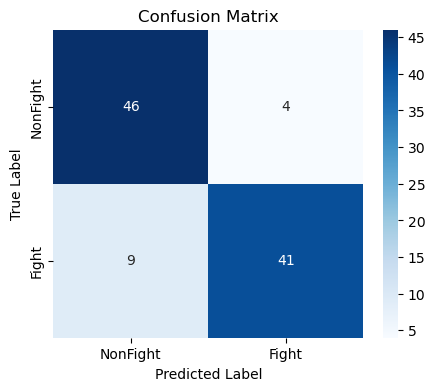

	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), # <-- where FlowerClient is of type flwr.client.NumPyClient object
	)
	Using `start_numpy_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flower-supernode` CLI command to start a SuperNode as shown below:

		$ flower-supernode --insecure --superlink='<IP>:<PORT>'

	To view all available options, run:

		$ flower-supernode --help

	Using `start_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      
INFO :      Received: get_parameters message b759e789-d578-4d9c-9353-d13ded166b37
INFO :      Sent reply
INFO :      Starting evaluation of initial global parameters
I

ROC-AUC Score: 0.8700
Client ready on device cuda:0


KeyboardInterrupt: 

In [12]:
if __name__ == "__main__":
    from multiprocessing import Process
    import time
    
    # Clear caches
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    
    # Run simulation
    run_simulation()